In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tables
import matplotlib as mpl
from scipy.optimize import curve_fit

In [2]:
mpl.rcParams["font.size"] = 16

In [3]:
path = "/home/zelenyy/data/sri-thunderstorm/aragats2020/res_2020.06.03.hdf5"

In [8]:
with tables.open_file(path) as h5file:
    for group in h5file.root:
        table = h5file.get_node(group, "particle_detector")
        print(repr(table.attrs))
        data = table.read()
        break
        print(table.nrows)

/sim0001/particle_detector._v_attrs (AttributeSet), 28 attributes:
   [CLASS := 'TABLE',
    FIELD_0_FILL := 0,
    FIELD_0_NAME := 'event',
    FIELD_1_FILL := 0,
    FIELD_1_NAME := 'particle',
    FIELD_2_FILL := 0.0,
    FIELD_2_NAME := 'energy',
    FIELD_3_FILL := 0.0,
    FIELD_3_NAME := 'theta',
    FIELD_4_FILL := 0.0,
    FIELD_4_NAME := 'radius',
    FIELD_5_FILL := 0.0,
    FIELD_5_NAME := 'time',
    NROWS := 2366796,
    TITLE := '',
    VERSION := '2.7',
    path := 'sim0001',
    text := '/npm/geometry/type custom\n/npm/thunderstorm/aragats/geo_type pie\n/npm/thunderstorm/physics standard_opt_4\n/npm/thunderstorm/cut/energy 0.05\n/npm/thunderstorm/height 3750 m\n/npm/thunderstorm/field_z 220 kV/m\n\n/gps/particle e-\n/gps/number 1\n/gps/direction 0 0 -1\n/gps/ene/mono 1.0 MeV\n/gps/position 0. 0. 499.5 m\n/run/beamOn 10000\nexit\n',
    values_cut := 0.05,
    values_direction := '0 0 -1',
    values_energy := 1.0,
    values_field_z := 220,
    values_number := 10000,


In [7]:
with tables.open_file(path) as h5file:
    for group in h5file.root:
        table = h5file.get_node(group, "particle_detector")
        a  = table.attrs
        print(a["values_physics"], a["values_type"],a["values_time"]/3600, table.nrows)
#         data = table.read()
#         break
#         print()

standard_opt_4 pie 21.171246759220956 2366796
standard_opt_4 pie 0.014138821127514044 2
standard pie 11.335181911844346 1778564
standard pie 0.009314847373300128 1
standard_opt_4 uniform 11.661698266114625 1477975
standard_opt_4 uniform 0.0123941290544139 0
standard uniform 7.138132373889287 1258867
standard uniform 0.008211307322813406 1


In [5]:
data.dtype.names

('event', 'particle', 'energy', 'theta', 'radius', 'time')

In [116]:
def process_data(data):
    element, counts = np.unique(data["particle"], return_counts=True)
    print(element, counts)
    print("Positron/Electron ratio: {:.4f}".format(counts[0]/counts[1]))
    

In [117]:
process_data(data)

[-11  11  22] [   1305  333039 2032452]
Positron/Electron ratio: 0.0039


(array([   657.,  10811.,  49900., 132572., 240090., 321621., 337007.,
        290724., 217779., 149691., 100377.,  69124.,  51004.,  40147.,
         32972.,  27679.,  23926.,  20890.,  18339.,  16418.]),
 array([3570.3149318 , 3641.79873691, 3713.28254202, 3784.76634713,
        3856.25015224, 3927.73395735, 3999.21776246, 4070.70156756,
        4142.18537267, 4213.66917778, 4285.15298289, 4356.636788  ,
        4428.12059311, 4499.60439822, 4571.08820333, 4642.57200844,
        4714.05581355, 4785.53961866, 4857.02342377, 4928.50722888,
        4999.99103399]),
 <a list of 20 Patch objects>)

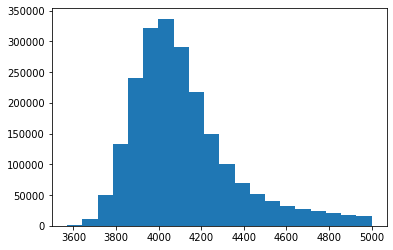

In [7]:
plt.hist(data["time"][data["time"]<5000], bins=20)

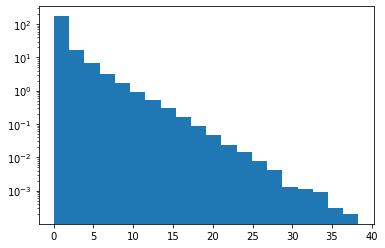

In [9]:
indx_gamma = data["particle"] == 22

temp = data["energy"][indx_gamma]
plt.hist(temp, bins = 20, weights=(1.0/10000)*np.ones(temp.size));
plt.yscale("log")

In [4]:
def exp(x, C, alpha):
    return C*np.exp(-alpha*x)

def lin(x, a, b):
    return a*x + b

In [118]:
def plot_hist(x, y, filename, fit=False):
    plt.clf()
    plt.bar(x[:-1], y, width=np.diff(x), align="edge", edgecolor="k")
#     print(x.shape, y.shape)
#     plt.step(x, y, where="mid")
#     _, bins, _ = plt.hist(data, bins, weights=(1.0/10000)*np.ones(data.size))

    if fit:
        x = (x[1:] + x[:-1])/2      
        popt, _ = curve_fit(lin, x, np.log(y))
        print(filename, popt)
        plt.plot(x, np.exp(lin(x, *popt)), "r", label="{:.2f}*exp(-{:.2f}*E)".format(np.exp(popt[0]), popt[1]))
        plt.legend()
    plt.title("Energy spectra per one seed electron ")
    plt.xlabel("Energy, MeV")
    plt.ylabel("particles\MeV")
    plt.grid(True)
    plt.yscale("log")
    plt.tight_layout()
    print(filename, np.diff(x)[0])
    plt.savefig(filename+ ".png", format="png", transparent = True, dpi=600)

    
def count_hist(data, bins):
    values, bins = np.histogram(data ,bins=bins)
    values = values/10000.0
    values /= np.diff(bins)
    return values, bins

def plot(data, particle = 22):
    if particle == 22:
        indx_gamma = data["particle"] == particle
    else:
        indx_gamma = data["particle"] != 22
    temp = data["energy"][indx_gamma]
    
    print("size", temp.size)
        
    if particle == 22:
        prefix = "gamma"
    else:
        prefix = "electron"
    
    values, bins = count_hist(temp ,bins=20)
    plot_hist(bins, values, prefix + "_general")
    
    indx_1_mev = data["energy"] < 1
    temp = data["energy"][np.logical_and(indx_gamma, indx_1_mev)]
    values, bins = count_hist(temp ,bins=20)
    plot_hist(bins, values, prefix + "_less_1_MeV")
    
    

    
    indx_over_1_mev = data["energy"] > 1
    temp = data["energy"][np.logical_and(indx_gamma, indx_over_1_mev)]
    
    
    values, bins = count_hist(temp ,bins=20)
    plot_hist(bins, values, prefix + "_over_1_MeV", fit=True)


size 2032452
gamma_general 1.9131209113664283
gamma_less_1_MeV 0.04749996459020427
gamma_over_1_MeV [-0.32612574  2.88699637]
gamma_over_1_MeV 1.865620875012515


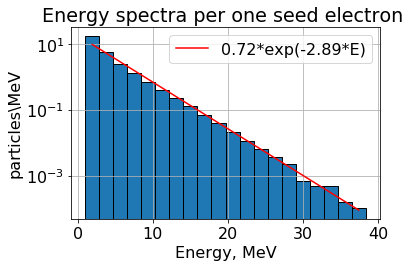

In [119]:
plot(data)

size 334344
electron_general 1.8691064969857343
electron_less_1_MeV 0.04749945201115463
electron_over_1_MeV [-0.28987186  2.50248027]
electron_over_1_MeV 1.8216058520917011


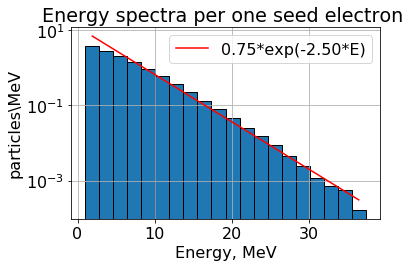

In [120]:
plot(data, particle=11)

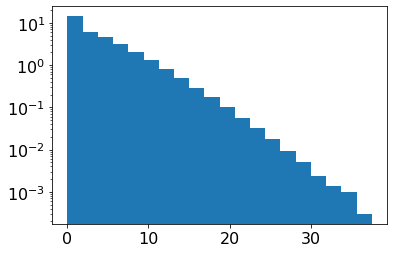

In [99]:
indx_gamma = data["particle"] != 22

temp = data["energy"][indx_gamma]
plt.hist(temp, bins = 20, weights=(1.0/10000)*np.ones(temp.size));
plt.yscale("log")

In [101]:
temp.size

227336

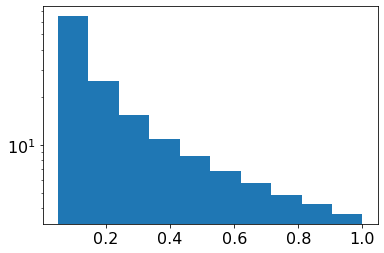

In [24]:
indx_gamma = data["particle"] == 22
indx_1_mev = data["energy"] < 1
temp = data["energy"][np.logical_and(indx_gamma, indx_1_mev)]
plt.hist(temp, weights=(1.0/10000)*np.ones(temp.size));
plt.yscale("log")

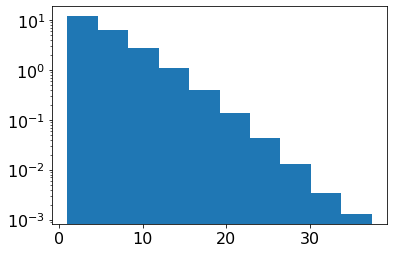

In [100]:
indx_gamma = data["particle"] != 22
indx_over_1_mev = data["energy"] > 1
temp = data["energy"][np.logical_and(indx_gamma, indx_over_1_mev)]
plt.hist(temp, weights=(1.0/10000)*np.ones(temp.size));
plt.yscale("log")

In [121]:
data["energy"].min()

0.050000031287873996

In [3]:
# EXAPCS electron

In [3]:
path = "/mnt/storage1/Загрузки/parma_cpp_orig/GeneOut/generation.out"


In [4]:
data = np.loadtxt(path, skiprows=3)


In [5]:
z = data[:, 3]
energy = data[:, 0]
xy = data[:, 1]**2 + data[:, 2]**2

/home/zelenyy/miniconda3/envs/phd-code/lib/python3.7/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  


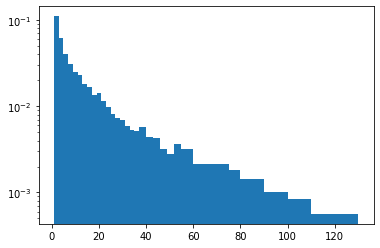

In [6]:
indx1 = energy < 150
indx2 = z < 0
indx3 = np.logical_and(indx1, energy>1)
indx = np.logical_and(indx2, indx3)
bins = np.array([1,  3.,   5.,   7.,   9.,  11.,  13.,  15.,  17.,  19.,  21.,  23.,  25.,  27.,  29.,
  31.,  33.,  35.,  37.,  40.,  43.,  46.,  49.,  52.,  55.,  60.,  75.,  80.,  90.,
 100., 110., 130.])
plt.hist(energy[indx]*np.abs(z[indx]), bins =bins, normed=True);
# xs = np.linspace(5, 75)
# plt.plot(xs, xs**(-1.5))
# xs = np.linspace(75, 130)
# plt.plot(xs, 0.1*xs**(-0.5))
plt.yscale("log")
# plt.xscale("log")

In [28]:
hist , bins = np.histogram(energy[indx]*np.abs(z[indx]))

In [29]:
def power(x, a, b):
    return a*(x**b)

In [30]:
from scipy.optimize import curve_fit

(array([4763., 2351., 1206.,  604.,  407.,  205.,  156.,  134.,   98.,
          76.]),
 array([-9.9997310e-01, -8.0009224e-01, -6.0021138e-01, -4.0033052e-01,
        -2.0044966e-01, -5.6880000e-04,  1.9931206e-01,  3.9919292e-01,
         5.9907378e-01,  7.9895464e-01,  9.9883550e-01]),
 <a list of 10 Patch objects>)

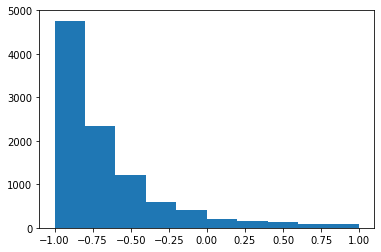

In [ ]:
plt.hist(z)

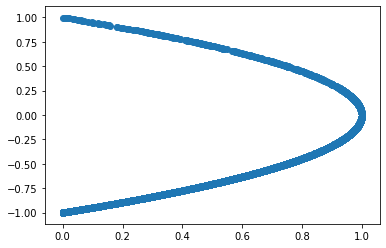

In [13]:

plt.scatter(xy, z)

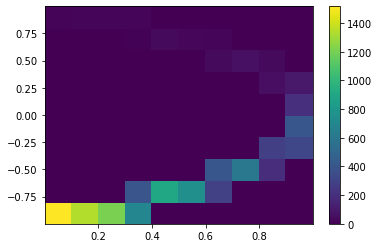

In [15]:
plt.hist2d(xy, z)
plt.colorbar()